#### Page rank <a name="page-rank"></a>

Lets make a graph of the Stars, when one user goes form *Rihanna* to *Madonna* then we create a directed edge *Rihanna* --> *Madonna* in our graph.

Now when we look at the graph we could simply say "ok, lets look at the $in$ degree of each node and the Star with the most in degree would be the most important person".

If the importance score of a Star is denoted by $\pi_u$ then $\pi_u = i_{u}$

But that would be maybe too easy and would not give us the best results. Maybe a star is more clicked on beacause it is in every page. For example, people want to find France and they know that *Jean Dujardin* comes from France but he is not everywhere, however *George Clooney* is on every wikipedia page, so they click on him and then click on *Jean Dujardin*. In our simple model looking only at in degrees, *George* would be more important, but the real important star is *Jean Dujardin*

So we will look at an other more complicated model: 

$\pi_{u} = \sum_{(v,u)}\frac{\pi_{v}}{o_{v}}$ <font size="1">where (u,v) denotes if there is a directed edge form v to u and o is the out degree of a node</font>

More important endorser = more important people 
Your importance is the sum of the importance of all the other peoples that point to you, but if  the person pointing to you is linked with a lot of other peoples then the importance of this link is diminushed. 

So we have a graph of people. Maybe the graph of people is circular and maybe there is a lot of stars, how do we find $\bar{\pi} = [\pi_{1}, \pi_{2}, ...., \pi_{n}]$ which satisfies the above condition ? 

We define the probability for a Random walk to go from node u to v as:
$$\begin{equation}
  H_{uv} =
    \begin{cases}
      1/o_{u} & \text{if $(u,v)\in E$}\\
      0 & \text{Otherwise}\\
    \end{cases}       
\end{equation}$$

So $H$ is the transition matrix of a RW on the graph 

And a "random surfer" has the probability of beeing on a node at a time $t+1$ defined as:
$p(t+1) = p(t)H$, we recognise here a markov chain. <br>If this markov chain is ergodic (non-periodic and strogly connected ie. no dead end) then $p(t) \rightarrow \pi$

To make it ergodic we have to connect the dangeling nodes to the graph 

We define: 
<br>$w=$ indicator of dangeling node <br> $e=$ vector full of 1's

So $\hat{H} = H + \frac{1}{n}(w^{T}e)$

Here we still have some cases where you can be stuck if for example you have a graph like this:<br>
A --> B <--> C, you will never go back to A.
So we implement another Matrix, the teleportation matrix: at every iteration you do a coin flip: with prob $\theta$ you walk on graph $\hat{H}$, with prob $1-\theta$ jump to a random node. 

$G = \theta\hat{H} + (1-\theta)\frac{e^{T}e}{n}$

This matrix can be further complicated by taking weights of the links and changing the definition of $H_{uv}$. For example somone could take this path *Gorge Clooney* --> *coffe* --> *Jean Dujardin* which should have a wheight smaller than a direct *Gorge Clooney* --> *Jean Dujardin*. Or we could take into account if more people took the route *Gorge Clooney* --> *Jean Dujardin* than the route *Francis Coppola* --> *Ariana Grande* then the weight between *Gorge Clooney* and *Jean Dujardin* should be higher. A lot of optimisation can be done to make our model stronger and more complete. 

#### How to find $\pi$ 

We are going to use the Power Method, we are not going to prove it here but basicaly you can calulate $\pi$ bit iterating 
$$\pi_{t+1} = \frac{\pi_{t} G}{\pi_{t} G e^{T}}$$

This will converge in about 50-100 iterations and then you just have to sort the arguments of your vector $\bar{\pi}$ to find the most important star. 


#### Applications and further possibilities of analysis 

We discused here about ranking stars but this method is applicable to a lot of other things like ranking historical (or not) events, books, movies, the wikipedia pages themselfs etc.. Anything that can be used. 

We could also rank the different pages by looking at the links on the HTML files and creating a graph with that and ranking the pages that way. You could then compare your ranking with the path that user took and the ranking with the html link and compare the two. Maybe there is interesting comparaisons to make. 

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import sys
import random 
 
# setting path for import 
from helpers import *

In [4]:
# Paths
folder_path = "dataset/wikispeedia_paths-and-graph/"
file_paths = ["paths_finished.tsv", "paths_unfinished.tsv", "categories.tsv", "articles.tsv", "links.tsv"]

# Datasets: Names and their columns name
data_frames_names = ["paths_finished", "paths_unfinished", "categories", "article", "links"]
dfs_headers = [
    ["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    ["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
    ["article", "category"],
    ["article"],
    ["linkSource", "linkTarget"]
]

# Download
dfs_skiprows = [16, 17, 13, 12, 12]
dfs = {}
for i in range(len(file_paths)):
    dfs[data_frames_names[i]] = pd.read_csv(folder_path + file_paths[i], sep='\t', header=None, names=dfs_headers[i], skiprows=range(dfs_skiprows[i]))

dfs = change_characters(dfs, 'paths_finished', 'path')
dfs['paths_finished'] = dfs['paths_finished'].drop(['hashedIpAddress', 'rating'], axis = 1)

dfs = change_characters(dfs, 'paths_unfinished', 'path')
dfs = change_characters(dfs, 'paths_unfinished', 'target')

In [6]:
def iter_and_add_to_graph(G, df):
    for index, row in df.iterrows():
        path = row['path'].split(';')
        for i in range(len(path)-1):
            G.add_edge(path[i], path[i+1])
    return G

def create_graph_path():
    G = nx.DiGraph()
    G = iter_and_add_to_graph(G, dfs['paths_unfinished'])
    G = iter_and_add_to_graph(G, dfs['paths_finished'])

    return G

In [8]:
G = create_graph_path()

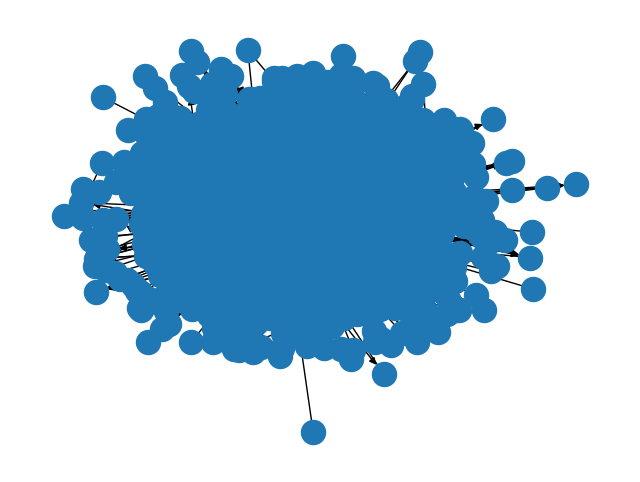

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
nx.draw(G, with_labels=False, ax=axes)

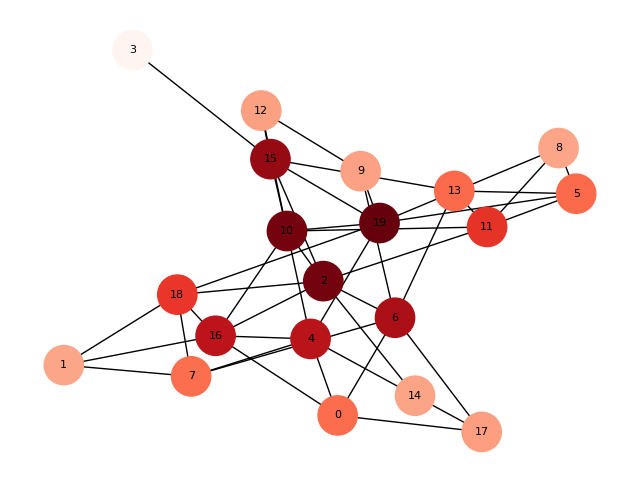

In [13]:
# Create a sample graph (you can replace this with your own graph)
G = nx.erdos_renyi_graph(20, 0.2)

# Calculate PageRank
pagerank = nx.pagerank(G)

# Extract PageRank values and normalize them for node color intensity
pagerank_values = list(pagerank.values())
norm_pagerank = [(x - min(pagerank_values)) / (max(pagerank_values) - min(pagerank_values)) for x in pagerank_values]

# Draw the graph with node colors based on PageRank
pos = nx.spring_layout(G)
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
nx.draw(G, pos, with_labels=True, cmap=plt.cm.Reds, node_color=norm_pagerank, node_size=800, font_size=8, ax=axes)

# Show the plot
plt.show()

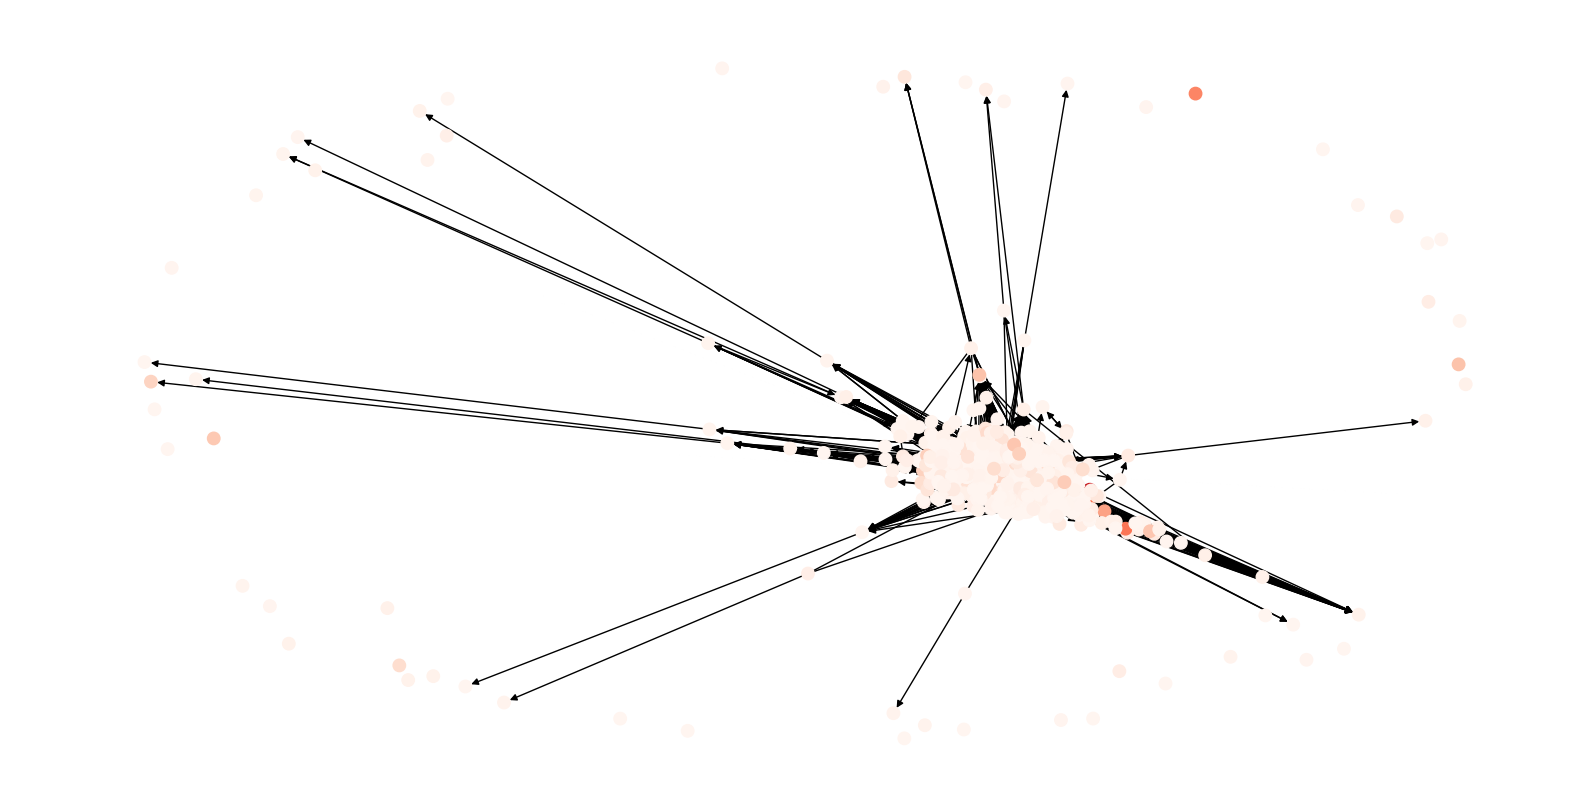

In [27]:
#G = nx.erdos_renyi_graph(1000, 0.05)
G = create_graph_path()

# Calculate PageRank
pagerank = nx.pagerank(G)

# Sample a fraction of nodes
fraction = 0.5
sampled_nodes = random.sample(G.nodes(), int(fraction * G.number_of_nodes()))

# Extract PageRank values and normalize them for node color intensity
pagerank_values = {node: pagerank[node] for node in sampled_nodes}
norm_pagerank = [(x - min(pagerank_values.values())) / (max(pagerank_values.values()) - min(pagerank_values.values())) for x in pagerank_values.values()]

# Create a subgraph with only the sampled nodes
subgraph = G.subgraph(sampled_nodes)

# Draw the subgraph with node colors based on PageRank
pos = nx.spring_layout(subgraph)
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
nx.draw(subgraph, pos, with_labels=False, cmap=plt.cm.Reds, node_color=norm_pagerank, node_size=80, font_size=6, ax=axes)

# Show the plot
plt.show()

In [31]:
print(pagerank)

{'Malawi': 0.00021230512466348346, 'Democracy': 0.00140766293567735, 'Alexander_the_Great': 0.0006138315991973917, 'Paraguay': 0.00016598971289437609, 'Bolivia': 0.0004121659969156343, 'Agriculture': 0.002193306097430437, 'History_of_the_world': 0.0001323662934069935, 'China': 0.003765992675695873, 'Yangtze_River': 0.0002033419089510299, 'Mind': 0.00028927344400681774, 'Christianity': 0.0030370445221646176, 'Europe': 0.008542567509928344, 'Renaissance': 0.0011950020915617201, 'Ancient_Greece': 0.001534855093795324, 'Afghanistan': 0.0007629220420226736, 'Asia': 0.0023446575277136124, '4-2-0': 4.605263157894738e-05, 'United_States': 0.014604960510474085, 'Sugar': 0.0005697814272757909, 'Australia': 0.00309123973886973, 'Logic': 0.00041562079432342903, 'Computer_science': 0.0005140518038206538, 'Science': 0.001638835947438275, 'Physical_science': 0.00011548437544635617, 'Astronomy': 0.0008083809412695164, 'Astrology': 0.00021584386082979814, 'Moon': 0.0009497014161367314, 'Apollo_11': 0.0

In [32]:
df_pagerank = pd.DataFrame(list(pagerank.items()), columns=['Node', 'PageRank'])

In [35]:
df_pagerank.sort_values(by=['PageRank'], ascending=False, inplace=True)
df_pagerank.head(10)

,Node,PageRank
64,<,0.036733
17,United_States,0.014605
11,Europe,0.008543
31,United_Kingdom,0.008115
51,England,0.006421
646,France,0.006370
36,World_War_II,0.006203
32,English_language,0.004965
166,Germany,0.004896
118,Africa,0.004354


/Applications/miniconda3/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


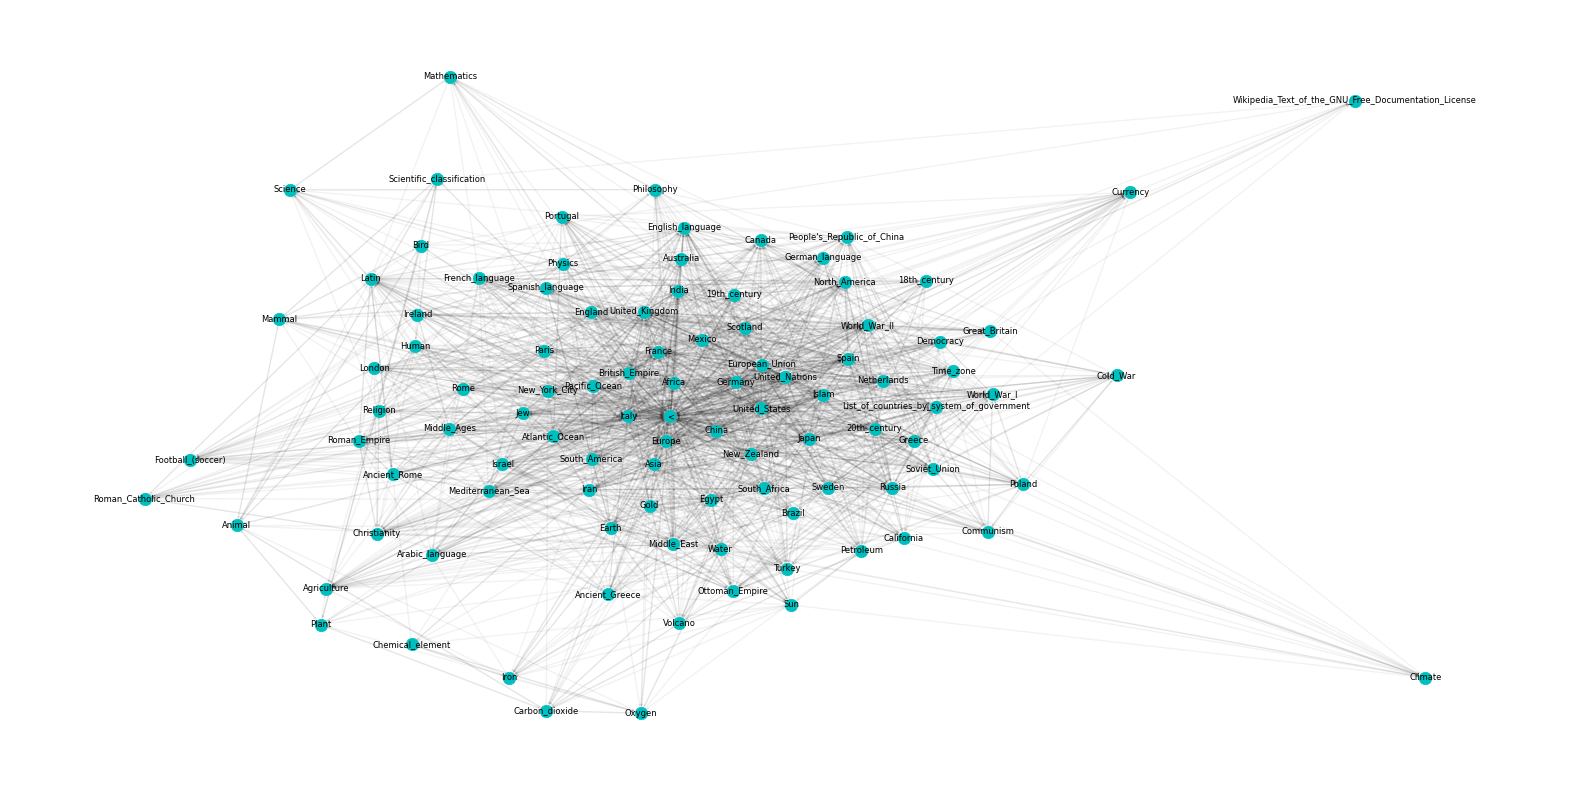

In [51]:
# Plots the 100 biggest nodes by PageRank
top_100_nodes = df_pagerank.head(100)['Node'].tolist()

subgraph = G.subgraph(top_100_nodes)

pos = nx.spring_layout(subgraph)
fig, axes = plt.subplots(1, 1, figsize=(20, 10))

edge_colors = [(0, 0, 0, 0.05) for _ in subgraph.edges()]

nx.draw(subgraph, pos, with_labels=True, cmap=plt.cm.Reds, node_color="c", node_size=80, font_size=6, font_color= "black", ax=axes,linewidths = 0.5, arrowsize=2, edge_color= edge_colors)

# Show the plot
plt.show()
